In [1]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
#imports
import numpy as np
import random as rd
import pandas as pd
import tensorflow as tf
from IPython.display import Video,Audio
import dlib
import cv2
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import pickle
import librosa
import librosa.display
tf.test.gpu_device_name()
#print("Done")

2024-07-26 21:32:53.794141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


''

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
rd.seed(seed_constant)
tf.random.set_seed(seed_constant)


In [3]:
dir = '/var/scratch/mpa326/'
video_folder = '/var/scratch/mpa326/Ravdess_dataset/Video_Speech'
audio_folder = '/var/scratch/mpa326/Ravdess_dataset/Audio_Speech'

In [4]:
getdf=f'{dir}/recognition_of_emotions_from_videos'

In [5]:
import sys
sys.path.append(getdf)

In [6]:
import getData 
df_video=getData.getdata(video_folder)
df_video.head()

,Audio_file,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,gender
0,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...,video-only,speech,neutral,normal,Kids are talking by the door,1st repetition,female
1,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...,video-only,speech,neutral,normal,Kids are talking by the door,2nd repetition,female
2,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...,video-only,speech,neutral,normal,Dogs are sitting by the door,1st repetition,female
3,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...,video-only,speech,neutral,normal,Dogs are sitting by the door,2nd repetition,female
4,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...,video-only,speech,calm,normal,Kids are talking by the door,1st repetition,female


In [7]:
df_video['gender']

0       female
1       female
2       female
3       female
4       female
         ...  
1435      male
1436      male
1437      male
1438      male
1439      male
Name: gender, Length: 1440, dtype: object

In [8]:
df_video_only=df_video[df_video.modality=='video-only']

In [9]:
df_video_only['gender'].value_counts()

gender
female    720
male      720
Name: count, dtype: int64

In [10]:
df_video_only['emotion'].value_counts()

emotion
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64

In [11]:
 df_video_only.groupby(['emotion', 'gender']).size().unstack()

gender,female,male
emotion,,
angry,96,96
calm,96,96
disgust,96,96
fearful,96,96
happy,96,96
neutral,48,48
sad,96,96
surprised,96,96


In [9]:
#!pip install get-video-properties

In [12]:
from videoprops import get_video_properties

def video_properties(lien:str) ->  dict:
  props = get_video_properties(lien)
  props_=dict()
  info=['codec_name','width','height','avg_frame_rate','display_aspect_ratio','nb_frames']
  for i in info:
    if i in ['width','height','nb_frames']:
      props_[i]=int(props[i])
    else:
      props_[i]=props[i]
  props_['duration']=float(props['duration'])
  props_['fps']=int(int(props['nb_frames'])//float(props['duration']))
  props_['dir']=lien
  
  return props_

In [13]:
video_properties('/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_01/02-01-01-01-01-02-01.mp4')

{'codec_name': 'h264',
 'width': 1280,
 'height': 720,
 'avg_frame_rate': '30000/1001',
 'display_aspect_ratio': '16:9',
 'nb_frames': 100,
 'duration': 3.336667,
 'fps': 29,
 'dir': '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_01/02-01-01-01-01-02-01.mp4'}

In [14]:
f=list(df_video_only.Audio_file)

In [15]:
print(f)

['/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-01-01-01-01-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-01-01-01-02-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-01-01-02-01-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-01-01-02-02-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-02-01-01-01-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-02-01-01-02-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-02-01-02-01-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-02-01-02-02-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-02-02-01-01-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-02-02-01-02-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-02-02-02-01-14.mp4', '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Act

In [16]:
df_video_properties=map(video_properties,f[:1440])

In [17]:
print(df_video_properties)

In [18]:
df_video_properties=list(df_video_properties)

In [19]:
print(df_video_properties)

[{'codec_name': 'h264', 'width': 1280, 'height': 720, 'avg_frame_rate': '30000/1001', 'display_aspect_ratio': '16:9', 'nb_frames': 104, 'duration': 3.470133, 'fps': 29, 'dir': '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-01-01-01-01-14.mp4'}, {'codec_name': 'h264', 'width': 1280, 'height': 720, 'avg_frame_rate': '30000/1001', 'display_aspect_ratio': '16:9', 'nb_frames': 100, 'duration': 3.336667, 'fps': 29, 'dir': '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-01-01-01-02-14.mp4'}, {'codec_name': 'h264', 'width': 1280, 'height': 720, 'avg_frame_rate': '30000/1001', 'display_aspect_ratio': '16:9', 'nb_frames': 104, 'duration': 3.470133, 'fps': 29, 'dir': '/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_14/02-01-01-01-02-01-14.mp4'}, {'codec_name': 'h264', 'width': 1280, 'height': 720, 'avg_frame_rate': '30000/1001', 'display_aspect_ratio': '16:9', 'nb_frames': 107, 'duration': 3.570233, 'fps': 29, 'dir': '/var/scratch/mpa326/Ravdess_dataset/V

In [20]:
df=pd.DataFrame(df_video_properties)
df.head()

,codec_name,width,height,avg_frame_rate,display_aspect_ratio,nb_frames,duration,fps,dir
0,h264,1280,720,30000/1001,16:9,104,3.470133,29,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...
1,h264,1280,720,30000/1001,16:9,100,3.336667,29,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...
2,h264,1280,720,30000/1001,16:9,104,3.470133,29,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...
3,h264,1280,720,30000/1001,16:9,107,3.570233,29,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...
4,h264,1280,720,30000/1001,16:9,112,3.737067,29,/var/scratch/mpa326/Ravdess_dataset/Video_Spee...


In [21]:
df.insert(1,"emotion",list(df_video_only.emotion))
df.insert(1,"gender",list(df_video_only.gender))

In [22]:
print(df)

     codec_name  gender    emotion  width  height avg_frame_rate  \
0          h264  female    neutral   1280     720     30000/1001   
1          h264  female    neutral   1280     720     30000/1001   
2          h264  female    neutral   1280     720     30000/1001   
3          h264  female    neutral   1280     720     30000/1001   
4          h264  female       calm   1280     720     30000/1001   
...         ...     ...        ...    ...     ...            ...   
1435       h264    male  surprised   1280     720     30000/1001   
1436       h264    male  surprised   1280     720     30000/1001   
1437       h264    male  surprised   1280     720     30000/1001   
1438       h264    male  surprised   1280     720     30000/1001   
1439       h264    male  surprised   1280     720     30000/1001   

     display_aspect_ratio  nb_frames  duration  fps  \
0                    16:9        104  3.470133   29   
1                    16:9        100  3.336667   29   
2                 

In [23]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 300):
   
  video_file = open(video_path, "rb").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""""")

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
emotion_labels = df['emotion']
genders = df['gender']

In [80]:
# def gender_split_train_test(df, emotion_labels, genders, gender_split=0.5):
#     # Verify the gender_split is between 0 and 1
#     if not 0 <= gender_split <= 1:
#         raise ValueError("gender_split should be between 0 and 1")

#     # Combine emotion labels and genders for stratification
#     combined_labels = [(e, g) for e, g in zip(emotion_labels, genders)]

#     # Create DataFrames for males and females
#     df_male = df[df['gender'] == 'male']
#     df_female = df[df['gender'] == 'female']
    
#     emotion_labels_male = [e for e, g in zip(emotion_labels, genders) if g == 'male']
#     emotion_labels_female = [e for e, g in zip(emotion_labels, genders) if g == 'female']
    
#     # Calculate the number of males and females required in the training set
#     total_train_size = int(0.8 * len(df))
#     n_males = int(gender_split * total_train_size)
#     n_females = total_train_size - n_males

#     # Ensure there are enough samples to meet the required split
#     if len(df_male) < n_males or len(df_female) < n_females:
#         raise ValueError("Not enough samples to meet the desired gender split")

#     # Split the DataFrames according to gender split
#     df_male_train, df_male_test, emotion_labels_male_train, emotion_labels_male_test = train_test_split(
#         df_male, emotion_labels_male, train_size=n_males, stratify=emotion_labels_male, random_state=42
#     )
    
#     df_female_train, df_female_test, emotion_labels_female_train, emotion_labels_female_test = train_test_split(
#         df_female, emotion_labels_female, train_size=n_females, stratify=emotion_labels_female, random_state=42
#     )
    
#     # Concatenate male and female DataFrames for train and test sets
#     X_train = pd.concat([df_male_train, df_female_train]).reset_index(drop=True)
#     X_test = pd.concat([df_male_test, df_female_test]).reset_index(drop=True)
    
#     y_train = emotion_labels_male_train + emotion_labels_female_train
#     y_test = emotion_labels_male_test + emotion_labels_female_test
    
#     gender_train = ['male'] * len(df_male_train) + ['female'] * len(df_female_train)
#     gender_test = ['male'] * len(df_male_test) + ['female'] * len(df_female_test)

#     # Return the final splits
#     return X_train, X_test, y_train, y_test, gender_train, gender_test

In [81]:
# X_train, X_test, y_train, y_test, gender_train, gender_test = gender_split_train_test(
#     df, emotion_labels, genders, gender_split=0.4
# )


In [83]:
# X_test['gender'].value_counts()

gender
male      260
female     28
Name: count, dtype: int64

In [85]:
combined_labels = [(e, g) for e, g in zip(emotion_labels, genders)]
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    df, emotion_labels, genders, test_size=0.2, stratify=combined_labels, random_state=42
)

print("Train set shape:", X_train.shape)
#print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

print("Label Train set shape:", y_train.shape)
#print("Label Validation set shape:", y_val.shape)
print("Label Test set shape:", y_test.shape)

print("GenderTrain set shape:", gender_train.shape)
#print("Gender Validation set shape:", gender_val.shape)
print("Gender Test set shape:", gender_test.shape)



Train set shape: (1152, 11)
Test set shape: (288, 11)
Label Train set shape: (1152,)
Label Test set shape: (288,)
GenderTrain set shape: (1152,)
Gender Test set shape: (288,)


In [90]:
X_train.groupby(['emotion', 'gender']).size().unstack()

gender,female,male
emotion,,
angry,77,77
calm,77,76
disgust,77,77
fearful,76,77
happy,77,77
neutral,38,38
sad,77,77
surprised,77,77


In [91]:
X_test.groupby(['emotion', 'gender']).size().unstack()

gender,female,male
emotion,,
angry,19,19
calm,19,20
disgust,19,19
fearful,20,19
happy,19,19
neutral,10,10
sad,19,19
surprised,19,19


#Since the train set has 576 of each gender remaining. In any of the training splits 576 can be the 60% of the training set, hence remaining 40% is 384 and total training set has 960 data points. Neutral emotion is left unchanged as there is already less data for it.

In [119]:
target_male_count = 384
target_female_count = 576

# Separate neutral and non-neutral emotions
neutral_data = X_train[X_train['emotion'] == 'neutral']
non_neutral_data = X_train[X_train['emotion'] != 'neutral']
print("NON",non_neutral_data['emotion'].value_counts())

# Separate neutral data by gender
neutral_males = neutral_data[neutral_data['gender'] == 'male']
neutral_females = neutral_data[neutral_data['gender'] == 'female']

# Count males and females in neutral data
neutral_male_count = len(neutral_males)
neutral_female_count = len(neutral_females)

# Separate non-neutral data by gender
non_neutral_males = non_neutral_data[non_neutral_data['gender'] == 'male']
non_neutral_females = non_neutral_data[non_neutral_data['gender'] == 'female']

# Calculate the current counts
current_male_count = len(non_neutral_males)
current_female_count = len(non_neutral_females)

# Calculate the number to drop for each gender
excess_male = max(0, current_male_count - target_male_count + neutral_male_count)
excess_female = max(0, current_female_count - target_female_count + neutral_female_count)

# Calculate how much excess data to drop equally from each emotion
emotion_counts = non_neutral_data['emotion'].value_counts()
emotions = emotion_counts.index

# Determine the number to drop from each emotion for both males and females
drop_per_emotion_male = excess_male / len(emotions) if excess_male > 0 else 0
drop_per_emotion_female = excess_female / len(emotions) if excess_female > 0 else 0

# Drop excess data equally across each emotion
def drop_excess(data, drop_per_emotion):
    # Initialize an empty DataFrame to store the result
    reduced_data = pd.DataFrame()
    for emotion in emotions:
        emotion_data = data[data['emotion'] == emotion]
        if drop_per_emotion > 0:
            # Drop excess samples from the emotion data
            if len(emotion_data) > drop_per_emotion:
                sampled_data = emotion_data.sample(n=len(emotion_data) - int(drop_per_emotion), random_state=42)
            else:
                sampled_data = emotion_data
        else:
            sampled_data = emotion_data
        reduced_data = pd.concat([reduced_data, sampled_data])
    return reduced_data

# Apply the dropping function
reduced_males = drop_excess(non_neutral_males, drop_per_emotion_male)
reduced_females = drop_excess(non_neutral_females, drop_per_emotion_female)

# Combine neutral data with the reduced non-neutral data
X_train_40m_60f = pd.concat([neutral_data, reduced_males, reduced_females])

# Ensure we reach the exact size of target counts
X_train_40m_60f = X_train_40m_60f.groupby('gender').apply(lambda x: x.sample(n=target_male_count if x['gender'].iloc[0] == 'male' else target_female_count, random_state=42)).reset_index(drop=True)

# Check the final shape and balance
print(X_train_40m_60f.shape)  # Should be (960, 11)
print(X_train_40m_60f['emotion'].value_counts())  # Check distribution of emotions
print(X_train_40m_60f['gender'].value_counts())   # Should be 480 males and 480 females

X_train_40m_60f.groupby(['emotion', 'gender']).size().unstack()


NON emotion
happy        154
angry        154
disgust      154
surprised    154
sad          154
calm         153
fearful      153
Name: count, dtype: int64
(960, 11)
emotion
disgust      127
happy        127
surprised    127
angry        126
sad          126
calm         126
fearful      125
neutral       76
Name: count, dtype: int64
gender
female    576
male      384
Name: count, dtype: int64


/tmp/ipykernel_18171/3209840511.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_train_40m_60f = X_train_40m_60f.groupby('gender').apply(lambda x: x.sample(n=target_male_count if x['gender'].iloc[0] == 'male' else target_female_count, random_state=42)).reset_index(drop=True)


gender,female,male
emotion,,
angry,77,49
calm,77,49
disgust,77,50
fearful,76,49
happy,77,50
neutral,38,38
sad,77,49
surprised,77,50


In [118]:
target_male_count = 576
target_female_count = 384

# Separate neutral and non-neutral emotions
neutral_data = X_train[X_train['emotion'] == 'neutral']
non_neutral_data = X_train[X_train['emotion'] != 'neutral']
print("NON",non_neutral_data['emotion'].value_counts())

# Separate neutral data by gender
neutral_males = neutral_data[neutral_data['gender'] == 'male']
neutral_females = neutral_data[neutral_data['gender'] == 'female']

# Count males and females in neutral data
neutral_male_count = len(neutral_males)
neutral_female_count = len(neutral_females)

# Separate non-neutral data by gender
non_neutral_males = non_neutral_data[non_neutral_data['gender'] == 'male']
non_neutral_females = non_neutral_data[non_neutral_data['gender'] == 'female']

# Calculate the current counts
current_male_count = len(non_neutral_males)
current_female_count = len(non_neutral_females)

# Calculate the number to drop for each gender
excess_male = max(0, current_male_count - target_male_count + neutral_male_count)
excess_female = max(0, current_female_count - target_female_count + neutral_female_count)

# Calculate how much excess data to drop equally from each emotion
emotion_counts = non_neutral_data['emotion'].value_counts()
emotions = emotion_counts.index

# Determine the number to drop from each emotion for both males and females
drop_per_emotion_male = excess_male / len(emotions) if excess_male > 0 else 0
drop_per_emotion_female = excess_female / len(emotions) if excess_female > 0 else 0

# Drop excess data equally across each emotion
def drop_excess(data, drop_per_emotion):
    # Initialize an empty DataFrame to store the result
    reduced_data = pd.DataFrame()
    for emotion in emotions:
        emotion_data = data[data['emotion'] == emotion]
        if drop_per_emotion > 0:
            # Drop excess samples from the emotion data
            if len(emotion_data) > drop_per_emotion:
                sampled_data = emotion_data.sample(n=len(emotion_data) - int(drop_per_emotion), random_state=42)
            else:
                sampled_data = emotion_data
        else:
            sampled_data = emotion_data
        reduced_data = pd.concat([reduced_data, sampled_data])
    return reduced_data

# Apply the dropping function
reduced_males = drop_excess(non_neutral_males, drop_per_emotion_male)
reduced_females = drop_excess(non_neutral_females, drop_per_emotion_female)

# Combine neutral data with the reduced non-neutral data
X_train_60m_40f = pd.concat([neutral_data, reduced_males, reduced_females])

# Ensure we reach the exact size of target counts
X_train_60m_40f = X_train_60m_40f.groupby('gender').apply(lambda x: x.sample(n=target_male_count if x['gender'].iloc[0] == 'male' else target_female_count, random_state=42)).reset_index(drop=True)

# Check the final shape and balance
print(X_train_60m_40f.shape)  # Should be (960, 11)
print(X_train_60m_40f['emotion'].value_counts())  # Check distribution of emotions
print(X_train_60m_40f['gender'].value_counts())   # Should be 480 males and 480 females

X_train_60m_40f.groupby(['emotion', 'gender']).size().unstack()


NON emotion
happy        154
angry        154
disgust      154
surprised    154
sad          154
calm         153
fearful      153
Name: count, dtype: int64
(960, 11)
emotion
disgust      127
surprised    127
happy        127
calm         126
angry        126
sad          126
fearful      125
neutral       76
Name: count, dtype: int64
gender
male      576
female    384
Name: count, dtype: int64


/tmp/ipykernel_18171/2924419213.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_train_60m_40f = X_train_60m_40f.groupby('gender').apply(lambda x: x.sample(n=target_male_count if x['gender'].iloc[0] == 'male' else target_female_count, random_state=42)).reset_index(drop=True)


gender,female,male
emotion,,
angry,49,77
calm,50,76
disgust,50,77
fearful,48,77
happy,50,77
neutral,38,38
sad,49,77
surprised,50,77


In [116]:
target_male_count = 480
target_female_count = 480

# Separate neutral and non-neutral emotions
neutral_data = X_train[X_train['emotion'] == 'neutral']
non_neutral_data = X_train[X_train['emotion'] != 'neutral']
print("NON",non_neutral_data['emotion'].value_counts())

# Separate neutral data by gender
neutral_males = neutral_data[neutral_data['gender'] == 'male']
neutral_females = neutral_data[neutral_data['gender'] == 'female']

# Count males and females in neutral data
neutral_male_count = len(neutral_males)
neutral_female_count = len(neutral_females)

# Separate non-neutral data by gender
non_neutral_males = non_neutral_data[non_neutral_data['gender'] == 'male']
non_neutral_females = non_neutral_data[non_neutral_data['gender'] == 'female']

# Calculate the current counts
current_male_count = len(non_neutral_males)
current_female_count = len(non_neutral_females)

# Calculate the number to drop for each gender
excess_male = max(0, current_male_count - target_male_count + neutral_male_count)
excess_female = max(0, current_female_count - target_female_count + neutral_female_count)

# Calculate how much excess data to drop equally from each emotion
emotion_counts = non_neutral_data['emotion'].value_counts()
emotions = emotion_counts.index

# Determine the number to drop from each emotion for both males and females
drop_per_emotion_male = excess_male / len(emotions) if excess_male > 0 else 0
drop_per_emotion_female = excess_female / len(emotions) if excess_female > 0 else 0

# Drop excess data equally across each emotion
def drop_excess(data, drop_per_emotion):
    # Initialize an empty DataFrame to store the result
    reduced_data = pd.DataFrame()
    for emotion in emotions:
        emotion_data = data[data['emotion'] == emotion]
        if drop_per_emotion > 0:
            # Drop excess samples from the emotion data
            if len(emotion_data) > drop_per_emotion:
                sampled_data = emotion_data.sample(n=len(emotion_data) - int(drop_per_emotion), random_state=42)
            else:
                sampled_data = emotion_data
        else:
            sampled_data = emotion_data
        reduced_data = pd.concat([reduced_data, sampled_data])
    return reduced_data

# Apply the dropping function
reduced_males = drop_excess(non_neutral_males, drop_per_emotion_male)
reduced_females = drop_excess(non_neutral_females, drop_per_emotion_female)

# Combine neutral data with the reduced non-neutral data
X_train_50m_50f = pd.concat([neutral_data, reduced_males, reduced_females])

# Ensure we reach the exact size of target counts
X_train_50m_50f = X_train_balanced.groupby('gender').apply(lambda x: x.sample(n=target_male_count if x['gender'].iloc[0] == 'male' else target_female_count, random_state=42)).reset_index(drop=True)

# Check the final shape and balance
print(X_train_50m_50f.shape)  # Should be (960, 11)
print(X_train_50m_50f['emotion'].value_counts())  # Check distribution of emotions
print(X_train_50m_50f['gender'].value_counts())   # Should be 480 males and 480 females

X_train_50m_50f.groupby(['emotion', 'gender']).size().unstack()


NON emotion
happy        154
angry        154
disgust      154
surprised    154
sad          154
calm         153
fearful      153
Name: count, dtype: int64
(960, 11)
emotion
happy        128
disgust      128
calm         127
sad          126
surprised    126
fearful      125
angry        124
neutral       76
Name: count, dtype: int64
gender
female    480
male      480
Name: count, dtype: int64


/tmp/ipykernel_18171/3613549186.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_train_50m_50f = X_train_balanced.groupby('gender').apply(lambda x: x.sample(n=target_male_count if x['gender'].iloc[0] == 'male' else target_female_count, random_state=42)).reset_index(drop=True)


gender,female,male
emotion,,
angry,62,62
calm,64,63
disgust,64,64
fearful,62,63
happy,64,64
neutral,38,38
sad,63,63
surprised,63,63


In [120]:
train_df_50m_50f = X_train_50m_50f.copy()
train_df_40m_60f = X_train_40m_60f.copy()
train_df_60m_40f = X_train_60m_40f.copy()



test_df = X_test.copy()


# Save to CSV files
train_df_50m_50f.to_csv('videotrain_set_50m_50f.csv', index=False)
train_df_40m_60f.to_csv('videotrain_set_40m_60f.csv', index=False)
train_df_60m_40f.to_csv('videotrain_set_60m_40f.csv', index=False)

test_df.to_csv('videotest_set.csv', index=False)

In [122]:
train_videos_path=list(X_train_50m_50f.dir)
test_videos_path = list(X_test.dir)
#print(videos_path)

In [123]:
print(len(train_videos_path))

960


In [124]:
Video(rd.sample(train_videos_path,1)[0],embed=True,width=300,height=300)
show_video(rd.sample(train_videos_path,1)[0])

In [125]:
SEQUENCE_LENGTH=20
(IMAGE_HEIGHT, IMAGE_WIDTH)=48,48

In [126]:
detector = dlib.get_frontal_face_detector()

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after detect face and resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video (faces).
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    # for frame_counter in tqdm_notebook(range(SEQUENCE_LENGTH)):
    for frame_counter in range(SEQUENCE_LENGTH):

         # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # detect and crop face in frame.
        faces = detector(frame, 0) 
        crop_img = frame[faces[0].top():faces[0].bottom(),faces[0].left():faces[0].right()]
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(crop_img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        resized_frame=cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)
        
        # Append the normalized frame into the frames list
        frames_list.append(resized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [127]:
frames=frames_extraction(rd.sample(train_videos_path,1)[0])

In [128]:
print(len(frames))

20


In [129]:
import time,sys
start = time.time()
t=frames_extraction('/var/scratch/mpa326/Ravdess_dataset/Video_Speech/Actor_03/02-01-01-01-01-01-03.mp4')
end = time.time()
print("The time of execution of above program is :", end-start)

The time of execution of above program is : 4.247759103775024


In [130]:
emotions_en=df_video_only.emotion.unique()

In [131]:
print(emotions_en)

['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']


In [2]:
#The below function is executed four times, thrice for three training splits and one for the test set. Replace 'X_test' with any of the above training sets
def create_dataset():

    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    genders = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(tqdm_notebook(emotions_en)):
            
            # Display the name of the class whose data is being extracted.
            print(f'Extracting Data of Class: {class_name}')
            
            # Get the list of video files present in the specific class name directory.
            files_list = list(X_test.dir[X_test.emotion == class_name])
            
            # Iterate through all the files present in the files list.
            for video_file_path in files_list:
                # Extract the frames of the video file.
                frames = frames_extraction(video_file_path)
                
                # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
                # So ignore the vides having frames less than the SEQUENCE_LENGTH.
                if len(frames) == SEQUENCE_LENGTH:
    
                    # Append the data to their repective lists.
                    features.append(frames)
                    labels.append(class_index)
                    genders.append(X_test.gender[X_test.dir == video_file_path].values[0])
                    video_files_paths.append(video_file_path)
    
        # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)
    genders = np.array(genders)
        
        # Return the frames, class index, and video file path.
    return {'features':features, 'labels':labels, 'genders':genders, 'video_files_paths':video_files_paths}

In [3]:
df=create_dataset()
datafile = open('video_test_common', 'ab')
pickle.dump(df, datafile)
datafile.close()
print(len(df['features']))

NameError: name 'tqdm_notebook' is not defined

In [161]:
video_file_paths = df.get('video_files_paths', [])
df = pd.DataFrame(video_file_paths, columns=['video_file_path'])
# Save to CSV
df.to_csv('video_test_paths.csv', index=False)

In [27]:
# datafile = open('video_data_new2', 'ab')
# pickle.dump(df, datafile)
# datafile.close()

In [33]:
print(len(df['features']))

1440


In [ ]:
#Audio Feature extracton

In [29]:
import getData
df_audio=getData.getdata(audio_folder)
df_audio.head()

,Audio_file,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,gender
0,/var/scratch/mpa326/Ravdess_dataset/Audio_Spee...,audio-only,speech,neutral,normal,Kids are talking by the door,1st repetition,male
1,/var/scratch/mpa326/Ravdess_dataset/Audio_Spee...,audio-only,speech,neutral,normal,Kids are talking by the door,2nd repetition,male
2,/var/scratch/mpa326/Ravdess_dataset/Audio_Spee...,audio-only,speech,neutral,normal,Dogs are sitting by the door,1st repetition,male
3,/var/scratch/mpa326/Ravdess_dataset/Audio_Spee...,audio-only,speech,neutral,normal,Dogs are sitting by the door,2nd repetition,male
4,/var/scratch/mpa326/Ravdess_dataset/Audio_Spee...,audio-only,speech,calm,normal,Kids are talking by the door,1st repetition,male


In [1]:
#2D audio features

NameError: name 'features' is not defined

In [149]:
#Create Spectrograms
def load_spec(audio_path, mode=0):

  wave, sr = librosa.load(audio_path,sr=None,mono=True)

  s, _ = librosa.effects.trim(wave,top_db=60)
  
    
  # generate (mel)spectrogram / mfcc
  if(mode == 1):
    s = librosa.feature.melspectrogram(y=s, sr=sr, hop_length=512)
  elif(mode == 2):

    s = librosa.feature.mfcc(y=s, sr=sr, n_mfcc=40)
  else:
    freqs, times, s = librosa.reassigned_spectrogram(y=s, sr=sr, hop_length=512)
    
  return s,sr

In [14]:
y, sr = load_spec(df_audio.Audio_file[8],1)

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
#from matplotlib.figure import Figure
fig = plt.Figure()
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
ax.set_axis_off()
p = librosa.display.specshow(librosa.power_to_db(y), ax=ax)
fig.savefig('spec.png',bbox_inches='tight',pad_inches=0.0)

NameError: name 'df_audio' is not defined

In [31]:
cv2.imread('spec.png').shape

(369, 496, 3)

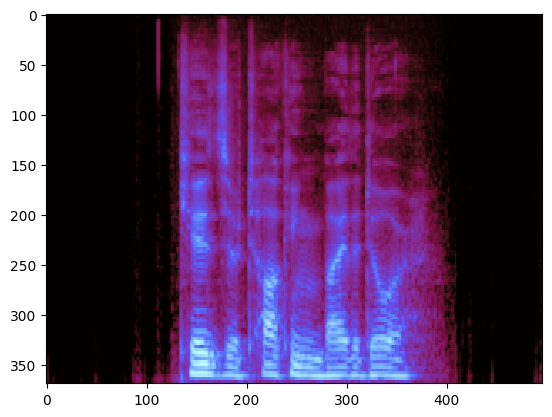

In [32]:
plt.imshow(cv2.imread('spec.png'))

In [72]:
df_audio.Audio_file[8].split('/')[-1].split('.')[0]

'03-01-02-02-01-01-01'

In [16]:
# train_df = pd.read_csv('audio_train_set.csv')
# val_df = pd.read_csv('audio_val_set.csv')
# test_df = pd.read_csv('audio_test_set.csv')

# # Extract paths, gender, and emotion labels from train set
# train_paths = train_df['Melspec path']  # Replace 'data' with the actual column name for paths if different
# train_genders = train_df['gender']
# train_emotions = train_df['emotion']

# # Extract paths, gender, and emotion labels from validation set
# val_paths = val_df['Melspec path']  # Replace 'data' with the actual column name for paths if different
# val_genders = val_df['gender']
# val_emotions = val_df['emotion']

# # Extract paths, gender, and emotion labels from test set
# test_paths = test_df['Melspec path']  # Replace 'data' with the actual column name for paths if different
# test_genders = test_df['gender']
# test_emotions = test_df['emotion']

# # Print or verify the extracted data
# print("Train paths:", train_paths.head())
# print("Train genders:", train_genders.head())
# print("Train emotions:", train_emotions.head())

# print("Validation paths:", val_paths.head())
# print("Validation genders:", val_genders.head())
# print("Validation emotions:", val_emotions.head())

# print("Test paths:", test_paths.head())
# print("Test genders:", test_genders.head())
# print("Test emotions:", test_emotions.head())

Train paths: 0    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
1    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
2    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
3    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
4    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
Name: Melspec path, dtype: object
Train genders: 0    female
1    female
2      male
3      male
4    female
Name: gender, dtype: object
Train emotions: 0        sad
1    fearful
2      angry
3    neutral
4      angry
Name: emotion, dtype: object
Validation paths: 0    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
1    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
2    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
3    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
4    /var/scratch/mpa326/ravdess_melspec_new/03-01-...
Name: Melspec path, dtype: object
Validation genders: 0      male
1    female
2      male
3    female
4      male
Name: gender, dtype: object
Validation emotions: 0      fe

In [57]:
#Spectrogram creation
labels = []
path_mels = []
genders = []
folder='/var/scratch/mpa326/ravdess_melspec_new/'
for class_index, class_name in enumerate(emotions_en):
            
            # Display the name of the class whose data is being extracted.
            print(f'Extracting Data of Class: {class_name}')
            
            # Get the list of video files present in the specific class name directory.
            files_list = list(train_df.melspec_path[train_df.emotion == class_name])
            
            # Iterate through all the files present in the files list.
            for video_file_path in files_list:
              y, sr = load_spec(video_file_path,1)
              fig = plt.Figure()
              canvas = FigureCanvas(fig)
              ax = fig.add_subplot(111)
              ax.set_axis_off()
              p = librosa.display.specshow(librosa.power_to_db(y), ax=ax)
              path=video_file_path.split('/')[-1].split('.')[0]
              fig.savefig(folder+path+'.png',bbox_inches='tight',pad_inches=0.0)
              labels.append(class_index)
              genders.append(df_audio.gender[df_audio.Audio_file == video_file_path].values[0])
              path_mels.append(folder+path+'.png')

Extracting Data of Class: neutral
Extracting Data of Class: calm
Extracting Data of Class: happy
Extracting Data of Class: sad
Extracting Data of Class: angry
Extracting Data of Class: fearful
Extracting Data of Class: disgust
Extracting Data of Class: surprised


In [162]:
#We read the video paths that we stored after feature extraction and apply this function to get them to look like spectrogram paths. 
# This is done so that alignment is ensured in the feature extraction across both modalities.
import os
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full column content
pd.set_option('display.expand_frame_repr', False) 
def create_new_path(old_path):
    # Extract the filename from the old path
    filename = os.path.basename(old_path)
    # Replace the first "02" with "03"
    new_filename = filename.replace("02", "03", 1)
    # Change the extension from .mp4 to .png
    new_filename = os.path.splitext(new_filename)[0] + '.png'
    # Create the new path
    new_path = f"/var/scratch/mpa326/ravdess_melspec_new/{new_filename}"
    return new_path
file_path1 = '/var/scratch/mpa326/Ravdess_code/Video_paths_for_audio_files/video_train_paths_50m_50f.csv'
file_path2 = '/var/scratch/mpa326/Ravdess_code/Video_paths_for_audio_files/video_train_paths_40m_60f.csv'
file_path3 = '/var/scratch/mpa326/Ravdess_code/Video_paths_for_audio_files/video_train_paths_60m_40f.csv'
file_path4 = '/var/scratch/mpa326/Ravdess_code/video_test_paths.csv'
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)
df4 = pd.read_csv(file_path4)
X_train_aud_50m_50f = pd.DataFrame()
X_train_aud_40m_60f = pd.DataFrame()
X_train_aud_60m_40f = pd.DataFrame()
X_test_aud = pd.DataFrame()
X_train_aud_50m_50f['melspec_path'] = df1['video_file_path'].apply(create_new_path)
X_train_aud_40m_60f['melspec_path'] = df2['video_file_path'].apply(create_new_path)
X_train_aud_60m_40f['melspec_path'] = df3['video_file_path'].apply(create_new_path)
X_test_aud['melspec_path'] = df4['video_file_path'].apply(create_new_path)
print(X_train_aud_m50_f50)
X_train_aud_50m_50f.to_csv('paths_train_audio_50m_50f.csv', index=False)
X_train_aud_40m_60f.to_csv('paths_train_audio_40m_60f.csv', index=False)
X_train_aud_60m_40f.to_csv('paths_train_audio_60m_40f.csv', index=False)
X_test_aud.to_csv('paths_test_audio.csv', index=False)


                                                         melspec_path
0    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-01-01-04.png
1    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-01-01-24.png
2    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-01-02-10.png
3    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-02-01-10.png
4    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-02-02-10.png
5    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-02-01-14.png
6    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-02-01-08.png
7    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-01-02-04.png
8    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-02-02-12.png
9    /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-02-02-24.png
10   /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-02-01-02.png
11   /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-01-01-02.png
12   /var/scratch/mpa326/ravdess_melspec_new/03-01-01-01-01-01-06.png
13   /var/scratch/mp

In [61]:
# import glob
# path_mels=glob.glob(folder+"*.png")

In [25]:
# train_df['emotion'] = pd.Categorical(train_df['emotion'], categories=emotions_en, ordered=True)

# # Sort the DataFrame based on the 'emotions' column
# train_df = train_df.sort_values(by='emotion')


In [27]:
# val_df['emotion'] = pd.Categorical(val_df['emotion'], categories=emotions_en, ordered=True)

# # Sort the DataFrame based on the 'emotions' column
# val_df = val_df.sort_values(by='emotion')


In [28]:
# test_df['emotion'] = pd.Categorical(test_df['emotion'], categories=emotions_en, ordered=True)

# # Sort the DataFrame based on the 'emotions' column
# test_df = test_df.sort_values(by='emotion')


In [29]:
# train_paths = train_df['melspec_path']  # Replace 'data' with the actual column name for paths if different
# train_genders = train_df['gender']
# train_emotions = train_df['emotion']

# # Extract paths, gender, and emotion labels from validation set
# val_paths = val_df['melspec_path']  # Replace 'data' with the actual column name for paths if different
# val_genders = val_df['gender']
# val_emotions = val_df['emotion']

# # Extract paths, gender, and emotion labels from test set
# test_paths = test_df['melspec_path']  # Replace 'data' with the actual column name for paths if different
# test_genders = test_df['gender']
# test_emotions = test_df['emotion']

In [45]:
# train_df = pd.read_csv('paths_train_audio.csv')
# val_df = pd.read_csv('paths_val_audio.csv')
# test_df = pd.read_csv('paths_test_audio.csv')

In [163]:
train_paths_aud_50m_50f = X_train_aud_50m_50f['melspec_path']
train_paths_aud_40m_60f = X_train_aud_40m_60f['melspec_path']
train_paths_aud_60m_40f = X_train_aud_60m_40f['melspec_path']
test_paths_aud = X_test_aud['melspec_path']

In [164]:
#Reading the spectrogram in the same file order as video features were extracted from the corrosponding video files.
df_train_aud_50m_50f=np.ones((960, 128, 128, 3),dtype='uint8')
df_train_aud_40m_60f=np.ones((960, 128, 128, 3),dtype='uint8')
df_train_aud_60m_40f=np.ones((960, 128, 128, 3),dtype='uint8')
df_test = np.ones((288, 128, 128, 3), dtype='uint8')
for i in range(960):
  img=cv2.imread(train_paths_aud_50m_50f[i])
  img=cv2.resize(img,(128, 128))
  df_train_aud_50m_50f[i]=img

for i in range(960):
  img=cv2.imread(train_paths_aud_40m_60f[i])
  img=cv2.resize(img,(128, 128))
  df_train_aud_40m_60f[i]=img

for i in range(960):
  img=cv2.imread(train_paths_aud_60m_40f[i])
  img=cv2.resize(img,(128, 128))
  df_train_aud_60m_40f[i]=img


for i in range(288):
    img=cv2.imread(test_paths_aud[i])
    img=cv2.resize(img,(128,128))
    df_test[i] = img

In [166]:
df1 = {'features':df_train_aud_50m_50f}
df2 = {'features':df_train_aud_40m_60f}
df3 = {'features':df_train_aud_60m_40f}
df4 = {'features':df_test}

In [167]:
datafile = open('audio_train_50m_50f', 'ab')
pickle.dump(df1, datafile)                     
datafile.close()

In [168]:
datafile = open('audio_train_40m_60f', 'ab')
pickle.dump(df2, datafile)                     
datafile.close()

In [169]:
datafile = open('audio_train_60m_40f', 'ab')
pickle.dump(df3, datafile)                     
datafile.close()

In [170]:
datafile = open('audio_test_common', 'ab')
pickle.dump(df4, datafile)                     
datafile.close()